In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
cpu = 40

In [3]:
def calculate_node_portion(sub_df):
    nodes_records = {}
    for k, v in node_cluster_dict.items():
        left = v['left']
        right = v['right']

        # left hypo, right hyper
        judge_from_left = sub_df['cluster_from'].apply(lambda i: i in left)
        judge_to_right = sub_df['cluster_to'].apply(lambda i: i in right)

        # right hypo, left hyper
        judge_from_right = sub_df['cluster_from'].apply(lambda i: i in right)
        judge_to_left = sub_df['cluster_to'].apply(lambda i: i in left)

        # this two cancel each other, use the remaining abs as real hits
        # positive means left hypo, negative means right hypo
        total = (judge_from_left & judge_to_right).sum() -\
                (judge_from_right & judge_to_left).sum()
        nodes_records[k] = total
    nodes_records = pd.Series(nodes_records) / node_possible_count
    return nodes_records

In [4]:
node_cluster_dict = joblib.load('/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.non_singleton_node_dict.lib')
related_dmg = pd.read_msgpack('RelatedDMG.msg')

gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
node_possible_count = {}
for node, sub_dict in node_cluster_dict.items():
    possible_pairs = len(sub_dict['left']) * len(sub_dict['right'])
    node_possible_count[node] = possible_pairs
node_possible_count = pd.Series(node_possible_count)

In [6]:
total_result = {}
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for gene, sub_df in related_dmg.groupby('gene_id'):
        future = executor.submit(calculate_node_portion, sub_df)
        futures[future] = gene
        
    for future in as_completed(futures):
        result = future.result()
        gene = futures[future]
        total_result[gene] = result
total_result = pd.DataFrame(total_result)

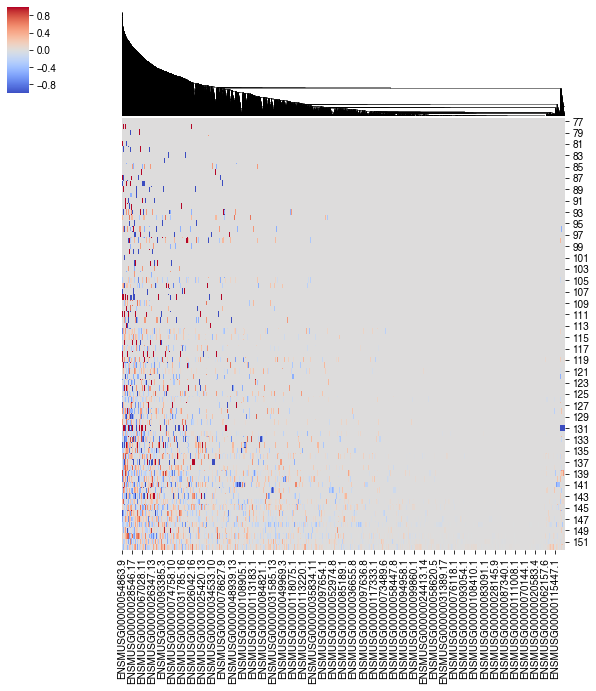

In [7]:
sns.clustermap(total_result, row_cluster=False, cmap='coolwarm')

In [8]:
total_result.to_msgpack('NodeGeneResults.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


In [9]:
total_result['ENSMUSG00000048251.15'][111]

-1.0

In [10]:
node_cluster_dict[111]

{'left': {'MGE-Sst Ptpre'}, 'right': {'MGE-Sst Unc5b'}}